### Make necessary imports

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import cv2

### Deterime location of river and non-river points, from a manually marked image, where a smudge of white appears at river locations and a smudge of black appears at non-river images

In [14]:
img = cv2.imread('images/extract_sample_points.jpg')

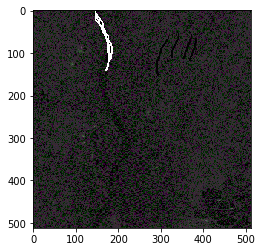

In [20]:
plt.imshow(img)

In [16]:
river_sample_locations = []
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if img[i][j][0] >= 250 and img[i][j][1] >= 250 and img[i][j][2] >= 250:
            river_sample_locations.append([i, j])

non_river_sample_locations = []
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if img[i][j][0] <= 2 and img[i][j][1] <= 2 and img[i][j][2] <= 2:
            non_river_sample_locations.append([i, j])

### Loop through all 512*512 pixels of the 4 bands given and create the tuples of the dataset for which we will predict classes

In [4]:
im1, im2, im3, im4 = Image.open('images/1.gif', 'r'), Image.open('images/2.gif', 'r'), Image.open('images/3.gif', 'r'), Image.open('images/4.gif', 'r')
r_band = np.array(list(im1.getdata())).reshape(512,512)
g_band = np.array(list(im2.getdata())).reshape(512,512)
b_band = np.array(list(im3.getdata())).reshape(512,512)
i_band = np.array(list(im4.getdata())).reshape(512,512)

all_data = []
for i in range(512) :
    row = []
    for j in range(512) :
        col = []
        col.append(r_band[i][j])
        col.append(g_band[i][j])
        col.append(b_band[i][j])
        col.append(i_band[i][j])
        row.append(col)
    all_data.append(row)
    
all_data = np.array(all_data)

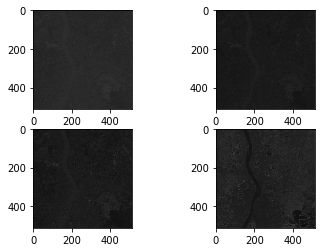

In [19]:
plt.subplot(2,2,1)
plt.imshow(im1)
plt.subplot(2,2,2)
plt.imshow(im2)
plt.subplot(2,2,3)
plt.imshow(im3)
plt.subplot(2,2,4)
plt.imshow(im4)

### From the previously extracted locations, we choose 50 river and 100 non-river points and extract intensity values at those locations

In [5]:
river_sample_intensities = []
for i in range(50):
    a, b = river_sample_locations[i]
    river_sample_intensities.append([r_band[a][b], g_band[a][b], b_band[a][b], i_band[a][b]])
river_sample_intensities = np.array(river_sample_intensities)

non_river_sample_intensities = []
for i in range(100):
    a, b = non_river_sample_locations[i]
    non_river_sample_intensities .append([r_band[a][b], g_band[a][b], b_band[a][b], i_band[a][b]])
non_river_sample_intensities = np.array(non_river_sample_intensities)

### These intesity values of 50 river samples and 150 non-river samples form out training dataset

In [6]:
train_data = np.vstack((river_sample_intensities, non_river_sample_intensities))

### We compute mean of river class, non-river class and whole training dataset

In [17]:
T1 = np.mean(river_sample_intensities, axis = 0)
T2 = np.mean(non_river_sample_intensities, axis = 0)
T_all = np.mean(train_data, axis = 0)

### We compute deviation of each sample point from its mean and use that to calculate the Covariance matrix for the river class, non-river class and all samples

In [8]:
dev_T1 = np.zeros(river_sample_intensities.shape)
for i in range(river_sample_intensities.shape[0]):
    for j in range(river_sample_intensities.shape[1]):
        dev_T1[i][j] = river_sample_intensities[i][j] - T1[j]

Cov_Mat1 = (float(1) / float(river_sample_intensities.shape[0])) * np.dot(np.transpose(dev_T1), dev_T1)

dev_T2 = np.zeros(non_river_sample_intensities.shape)
for i in range(non_river_sample_intensities.shape[0]):
    for j in range(non_river_sample_intensities.shape[1]):
        dev_T2[i][j] = non_river_sample_intensities[i][j] - T2[j]

Cov_Mat2 = (float(1) / float(non_river_sample_intensities.shape[0])) * np.dot(np.transpose(dev_T2), dev_T2)


dev_T_all = train_data - T_all
Cov_Mat_all = (float(1) / float(train_data.shape[0])) * np.dot(np.transpose(dev_T_all), dev_T_all)

### We define a function to predict class for each pixel of given image, by comparing the predicted probabilities of a pixel location being of river or non-river

In [10]:
def predict_pixel_values(P1, P2):
    output = np.zeros((512, 512))
    for i in range(512):
        for j in range(512):
            dev_T1 = np.zeros(all_data[i][j].shape)
            for k in range(dev_T1.shape[0]):
                dev_T1[k] = all_data[i][j][k] - T1[k]
                
            river_class = np.dot(np.dot(np.transpose((dev_T1)), np.linalg.inv(Cov_Mat1)), dev_T1)
            p1 = (float(1) / ((float(2) * np.pi) ** 2)) * (float(1) / (np.sqrt(np.linalg.det(Cov_Mat1)))) * np.exp((float(-0.5)) * river_class)

            dev_T2 = np.zeros(all_data[i][j].shape)
            for k in range(dev_T2.shape[0]):
                dev_T2[k] = all_data[i][j][k] - T2[k]
            non_river_class = np.dot(np.dot(np.transpose((dev_T2)), np.linalg.inv(Cov_Mat2)), dev_T2)
            p2 =  (float(1) / ((float(2) * np.pi) ** 2)) * (float(1) / (np.sqrt(np.linalg.det(Cov_Mat2)))) * np.exp((float(-0.5)) * non_river_class)

            if(P1 * p1 >= P2 * p2) :
                output[i][j] = 255
            else :
                output[i][j] = 0

    im = Image.fromarray(output)
    im1 = Image.fromarray(255 - output)
    plt.subplot(1,2,1)
    plt.imshow(im)
    plt.subplot(1,2,2)
    plt.imshow(im1)

### Case 1

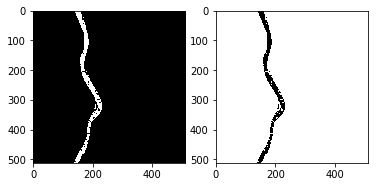

In [11]:
P1 = 0.7
P2 = 0.3
predict_pixel_values(P1, P2)


### Case 2

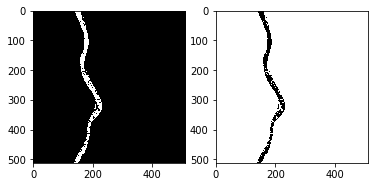

In [12]:
P1 = 0.3
P2 = 0.7
predict_pixel_values(P1, P2)

### Case 3

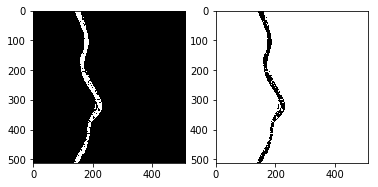

In [13]:
P1 = 0.5
P2 = 0.5
predict_pixel_values(P1, P2)